In [1]:
# IMDB 데이터셋 로드

from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) # train_data에서 자주 나타나는 단어 1만개만 사용

Using TensorFlow backend.


In [2]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [3]:
train_labels[0]

1

In [4]:
max([max(sequence) for sequence in train_data]) # 최대 단어 index는 9,999

9999

In [5]:
# 원래의 영어 단어로 변환

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 나타내는 index이므로 3을 뺌
# 단어 사전에 없는 경우는 '?'로 대체
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

In [6]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [7]:
# integer sequence를 binary matrix로 encoding
# one-hot-encoding, list를 tensor로 변환
# data 변환

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    
    return results

vector_train_data = vectorize_sequences(train_data) # train data 25,000개
vector_test_data = vectorize_sequences(test_data) # test data 25,000개

In [8]:
vector_train_data[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
# label 변환

vector_train_labels = np.asarray(train_labels).astype('float32') # train labels 25,000개
vector_test_labels = np.asarray(test_labels).astype('float32') # test labels 25,000개

In [10]:
# 신경망 모델 만들기

from keras import models
from keras import layers

def build_model():
    model = models.Sequential()

    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [11]:
# validation set 준비

# train data 25,000개 >>> partial train data 15,000개 + partial test data 10,000개

# data
partial_train_data = vector_train_data[:15000] # 15,000개
partial_test_data = vector_train_data[15000:] # 10,000개

# labels
partial_train_labels = vector_train_labels[:15000] # 15,000개
partial_test_labels = vector_train_labels[15000:] # 10,000개

## 3-fold cross validation

> partial_train_data 15,000개로 3-fold cross validation (training + validation)<br/>
> partial_test_data 10,000개로 evaluate 후 hyperparameters tuning해서 overfitting minimizing (강의 내용 범주 안 구현)<br/>
> test_data 25,000개로 최종 evaluate, predict (test)

In [21]:
# 3-fold cross validation

k = 3
n_val_samples = len(partial_train_data) // k

n_epochs = 20

loss_scores = []
acc_scores = []

for i in range(k): # i == 0, 1, 2
    print('processing fold #', i)
    
    # 폴드 검증 데이터
    fold_val_data = partial_train_data[i * n_val_samples:(i+1) * n_val_samples]
    fold_val_labels = partial_train_labels[i * n_val_samples:(i+1) * n_val_samples]
    
    # 폴드 훈련 데이터
    fold_train_data = np.concatenate([partial_train_data[:i * n_val_samples], partial_train_data[(i+1) * n_val_samples:]], axis=0)
    fold_train_labels = np.concatenate([partial_train_labels[:i * n_val_samples], partial_train_labels[(i+1) * n_val_samples:]], axis=0)
    
    model = build_model() # 모델 정의
    
    history = model.fit(fold_train_data, # 모델 폴드 훈련
                        fold_train_labels,
                        epochs=n_epochs,
                        batch_size=512,
                        verbose=0)
    
    fold_val_loss, fold_val_acc = model.evaluate(fold_val_data, fold_val_labels, verbose=0)
    
    loss_scores.append(fold_val_loss)
    acc_scores.append(fold_val_acc)

processing fold # 0
processing fold # 1
processing fold # 2


In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [22]:
loss_scores

[0.6350265875339508, 0.6376359125614166, 0.7045293752253056]

In [23]:
acc_scores

[0.8610000014305115, 0.8628000020980835, 0.8614000082015991]

In [24]:
np.mean(loss_scores) # 최종 validation loss

0.6590639584402243

In [25]:
np.mean(acc_scores) # 최종 validation accuracy

0.8617333372433981

----------------------------------------------------- Still doing ----------------------------------------------------------------

In [12]:
# 모델 훈련

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 197us/step - loss: 0.5231 - acc: 0.7793 - val_loss: 0.3940 - val_acc: 0.8663
Epoch 2/20
15000/15000 [==============================] - 3s 168us/step - loss: 0.3114 - acc: 0.9010 - val_loss: 0.3131 - val_acc: 0.8823
Epoch 3/20
15000/15000 [==============================] - 2s 163us/step - loss: 0.2261 - acc: 0.9277 - val_loss: 0.2863 - val_acc: 0.8877
Epoch 4/20
15000/15000 [==============================] - 3s 180us/step - loss: 0.1811 - acc: 0.9416 - val_loss: 0.2817 - val_acc: 0.8867
Epoch 5/20
15000/15000 [==============================] - 3s 168us/step - loss: 0.1472 - acc: 0.9513 - val_loss: 0.2956 - val_acc: 0.8833
Epoch 6/20
15000/15000 [==============================] - 3s 167us/step - loss: 0.1203 - acc: 0.9629 - val_loss: 0.3178 - val_acc: 0.8801
Epoch 7/20
15000/15000 [==============================] - 2s 164us/step - loss: 0.1009 - acc: 0.9708 - val_loss: 0.3116 - 

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

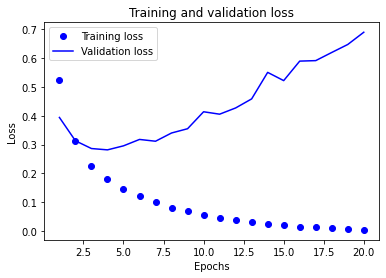

In [14]:
# training, validation loss 그리기

import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

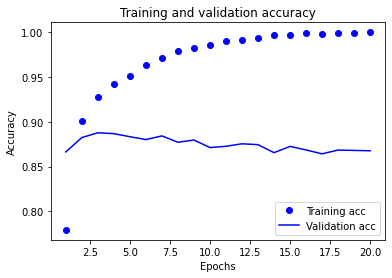

In [15]:
# training, validation accuracy 그리기

plt.clf() # 그래프 초기화

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
# 모델 재훈련

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)

results = model.evaluate(vector_test_data, vector_test_labels) # test data로 평가

Epoch 1/4
25000/25000 [==============================] - 3s 111us/step - loss: 0.4602 - accuracy: 0.8251
Epoch 2/4
25000/25000 [==============================] - 3s 111us/step - loss: 0.2676 - accuracy: 0.9096
Epoch 3/4
25000/25000 [==============================] - 3s 109us/step - loss: 0.2043 - accuracy: 0.9289
Epoch 4/4
25000/25000 [==============================] - 4s 146us/step


In [17]:
# 최종 결과 확인

results

[0.3018812312412262, 0.8814799785614014]

In [18]:
# 새로운 데이터 예측

model.predict(vector_test_data)

array([[0.16196543],
       [0.9999101 ],
       [0.805817  ],
       ...,
       [0.09962112],
       [0.05827034],
       [0.5565213 ]], dtype=float32)